# Python and C++ extension

## Importing library

In [6]:
import sys # Importing the library that we have to use
sys.path.append('/content/CppToPython')

In [7]:
import numpy as np
import GeDiM4Py as gedim
# Installed in the virtual machine - is the main library implemented
# in polito

### Initialize
We select a specific space of $V\delta$. The space which contain the finite element. A **finite element** is a sort of approximation of the solution using contiunuos polynomial. The $\delta$ is the lenght of the subinterval that we use to discretize the $[a,b]$ interval of the solution. We use polynomial of order k to solve in $[a,b]$ the pde. So **k** is the order of the model that we use.

The **main idea** is that we approximate the solution in each interval with polynomial of order k. We chose polynomial that are continuous cell-by-cell. We want *continuity* in each part of the local polynomial.

**Descite fine element solution** is an approximation of $u$ which is locally a polynomial of degree $k$ and locally continuous.

The main **idea** is that in a 1D space we have intervall, in 2D space (or more) we have a grid to build (for example we can discretize the domain the square, triangle and more). Pay attention: we work on the lenght not the area of the mash (or tasselation).

In [8]:
# We are just user of the finite element implemented in the library (1D or 2D)
lib = gedim.ImportLibrary("/content/CppToPython/release/GeDiM4Py.so")

config = { 'GeometricTolerance': 1.0e-8 } # We give the tol
# The lenght less then tol is considered 0, to set to 0 some cell of the grid
gedim.Initialize(config, lib)

## Elliptic Equation

Solving the following equation on square $\bar{\Omega} = [0, 1] \times [0, 1]$

$$
\begin{cases}
\nabla \cdot (a \nabla u) + b \cdot \nabla u + c u = f & \text{in } \Omega\\
a \nabla u \cdot n_1 = g_1 & \text{in } \Gamma_{left} \text{  Neuman condition}\\
a \nabla u \cdot n_2 = g_2 & \text{in } \Gamma_{right} \text{  Neuman condition}\\
u = 1.1 & \text{in } ∂Ω∖ (\Gamma_{left} ∪ \Gamma_{right}) \text{  Dirichlet condition}
\end{cases}
$$

where $u = 16 xy(1-x)(1-y) + 1.1$, this is the solution, that is a polynomial of degree 4.

**Phisic meaning of the parameter**:
- $a$ is the diffiusion parameters
- $b$ is the advection term
- $c$ is the reaction term
- $f$ is the forcing term

The *Neuman boundary condition* is also called weak, on the contrary, the *Dirichlet* are colled strick.

In [9]:
# We set the a, b, c parameters
def Poisson_A():
	return 10.0
def Poisson_B():
	return 0.1
def Poisson_C():
	return 2.0

def Poisson_a(numPoints, points):
	values = np.ones(numPoints) * Poisson_A()
	return values.ctypes.data

def Poisson_b(numPoints, points):
	values = np.ones((2, numPoints)) * Poisson_B()
	return values.ctypes.data

def Poisson_c(numPoints, points):
	values = np.ones(numPoints) * Poisson_C()
	return values.ctypes.data

# We want to test the correctness of the solution
# So we put f in order to have u = 16 xy(1-x)(1-y) + 1.1
# as a solution
def Poisson_f(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = Poisson_A() * 32.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) + matPoints[0,:] * (1.0 - matPoints[0,:])) + \
	Poisson_B() * 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:]) + \
	Poisson_B() * 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:]) + \
	Poisson_C() * 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) + Poisson_C() * 1.1
	return values.ctypes.data

# Exact solution
def Poisson_exactSolution(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) + 1.1
	return values.ctypes.data

# The gradient with two direction (0=X and 1=Y)
# Here, the derivative of Z is not present
def Poisson_exactDerivativeSolution(direction, numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)

	if direction == 0:
		values = 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	elif direction == 1:
		values = 16.0 * (1.0 - 2.0 * matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])
	else:
		values = np.zeros(numPoints)

	return values.ctypes.data

# Dirichlet
def Poisson_strongTerm(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = 16.0 * (matPoints[1,:] * (1.0 - matPoints[1,:]) * matPoints[0,:] * (1.0 - matPoints[0,:])) + 1.1
	return values.ctypes.data

# The two Neumann boundary condition
# We use u as did before, so we compute the boundary conditon
# So the u is the solution that we want
# We want to test the correctness of the library in this occasion
def Poisson_weakTerm_right(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = Poisson_A() * 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	return values.ctypes.data

def Poisson_weakTerm_left(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = - Poisson_A() * 16.0 * (1.0 - 2.0 * matPoints[0,:]) * matPoints[1,:] * (1.0 - matPoints[1,:])
	return values.ctypes.data

### Define Simulation Parameters

In [10]:
# The library requires the AREA of the triangle that we want
# To use to performe the mesh
meshSize = 0.1 # Is the lenght of the mesh, is delta (in general is the lenght)
order = 1 # We have to fix the order k of the metod
# Now we work with polynomial of order 2

### Create Mesh

The library accepts the possibility to create square domains and rectangle domains.

To description of the domain borders are passed to the library for the vertices and the edges of the domain as integer values called `markers`.
Each `marker` identifies a different boundary condition.

__In this example__:

 `marker=2` identifies $Γ_{right}$, `marker=3` identifies $Γ_{left}$ and `marker=1` identifies the Dirichlet boundary.

In [11]:
# Description of the domain centered in the origin (0,0) and is ortogonal
# To the space (see the picture)
# 'DiscretizationType': 1 means triangular
domain = { 'SquareEdge': 1.0, 'VerticesBoundaryCondition': [1,1,1,1], 'EdgesBoundaryCondition': [1,2,1,3], 'DiscretizationType': 1, 'MeshCellsMaximumArea': meshSize }
[meshInfo, mesh] = gedim.CreateDomainSquare(domain, lib) # We create the mesh

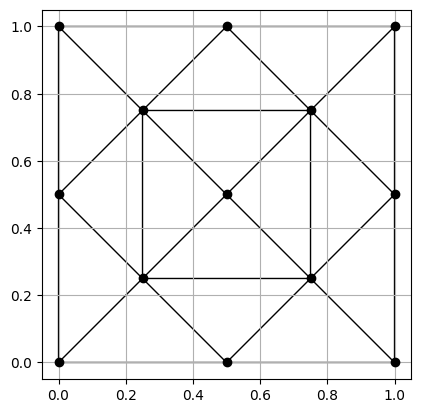

In [ ]:
gedim.PlotMesh(mesh) # Just plot the mesh
# We can see that the domain (the square) is divided in triangle

### Create Discrete Space FEM
The boundary condition types are passed to the library during the creation of the discrete space.
The types are the following:
* `BoundaryConditionType=1`: internal mesh point;
* `BoundaryConditionType=2`: strong boundary mesh point (Dirichlet in this example);
* `BoundaryConditionType=3`: weak boundary mesh point (Neumann in this example).
The array `BoundaryConditionType` describes for each `marker` the type of boundary condition associated.

__NB__: the array has dimension `num_markers+1`, as the first element is associated to non-usable `marker=0`.

__In this example__:

we have $3$ different markers, thus `BoundaryConditionsType` has size $3+1=4$. In particular `marker=1` has type `BoundaryConditionsType[1]=2` (Dirichlet), `marker=2` has type `BoundaryConditionsType[2]=3` and `marker=3` (Neumann) has type `BoundaryConditionsType[3]=3` (Neumann).

In [12]:
# Always type:1 because is fem discretization
# BoundaryConditionsType: array of dimensinon the number of
# Conditions we have +1 (we have 3 bc, so in the array there are 4 elements)
# For each boundary condition we have to tell if it is weak (3) or strong (2)
# If it is NOT a specific condition (1), so it means the "rest part"
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 2, 3, 3] } # QUESTION NON HO CAPITO PERCHè QUA METTIAMO 1
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

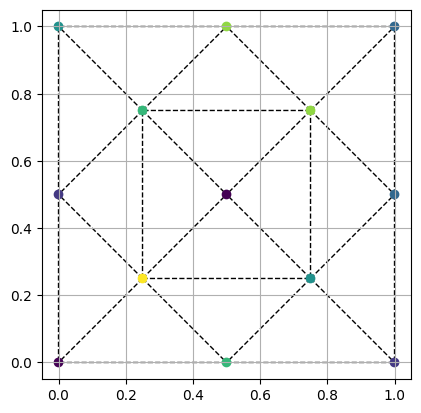

In [14]:
gedim.PlotDofs(mesh, dofs, strongs)
# Why the poits are colored? Different colors means different
# Degrees of freedom

# NON HO BEN CAPITO IN CHE MODO VENGONO ASSEGNATI I COLORI

### Assemble linear system

In [15]:
# We use the discrete space to create the linear system
# stiffness matrix (or diffiusion matrix) is related to (grad (a grad u))
# To discretize stiffness we fixed delta
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Poisson_a, problemData, lib)

# Matrix related to the other part of the bilinear form
[advection, advectionStrong] = gedim.AssembleAdvectionMatrix(Poisson_b, problemData, lib)
[reaction, reactionStrong] = gedim.AssembleReactionMatrix(Poisson_c, problemData, lib)

# The element in the right part of the equations
forcingTerm = gedim.AssembleForcingTerm(Poisson_f, problemData, lib)

solutionStrong = gedim.AssembleStrongSolution(Poisson_strongTerm, 1, problemData, lib)

weakTerm_right = gedim.AssembleWeakTerm(Poisson_weakTerm_right, 2, problemData, lib)
weakTerm_left = gedim.AssembleWeakTerm(Poisson_weakTerm_left, 3, problemData, lib)

### Solve linear system

In [16]:
# Assemble the linear system
# We need to solve this system to find the solution
# We do that with Gauss (LU) factorization
solution = gedim.LUSolver(stiffness + advection + reaction, \
    forcingTerm - \
    (stiffnessStrong + advectionStrong + reactionStrong) @ solutionStrong + \
    weakTerm_right + \
    weakTerm_left, lib)

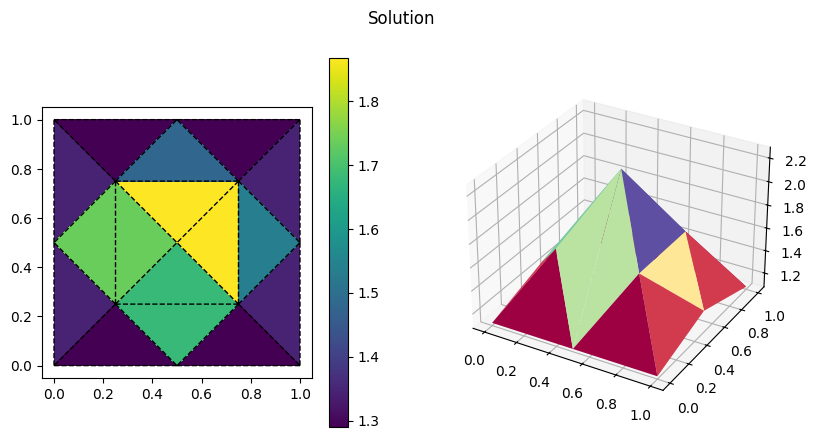

In [17]:
gedim.PlotSolution(mesh, dofs, strongs, solution, solutionStrong)
# This has to be the polynomial
# We put in the linear system some weak and other strong condition
# So same of them are solved taking in account that the boundary
# Has to be solved in a perfect way
# Other, with less accuracy, so they are not perfectly equal to the right
# solution u that we know

# HOW WE CAN IMPROVE? If we change the size of the mehs
# We can achieve a best discretizatin and so also
# A best solution
# i.e. meshSize = 0.001

In [19]:
# Related to the project, this is a way to export things
gedim.ExportSolution(Poisson_exactSolution, solution, solutionStrong, lib)

### Compute errors
We can controll the error of the solution (see the theory).

In [20]:
errorL2 = gedim.ComputeErrorL2(Poisson_exactSolution, solution, solutionStrong, lib)

errorH1 = gedim.ComputeErrorH1(Poisson_exactDerivativeSolution, solution, solutionStrong, lib)

print("dofs", "h", "errorL2", "errorH1") # h = delta
print(problemData['NumberDOFs'], '{:.16e}'.format(problemData['H']), '{:.16e}'.format(errorL2), '{:.16e}'.format(errorH1))

dofs h errorL2 errorH1
7 5.0000000000000000e-01 6.5007943036846483e-02 1.0131118597232218e+00


## Heat Conductivity Equation

Solving the following equation on square $\bar{\Omega} = [-1, +1] \times [-1, +1]$

$$
\begin{cases}
\nabla \cdot (k \nabla u) = 0 & \text{in } \Omega\\
k \nabla u \cdot n_1 = g & \text{in } \Gamma_{down}\\
u = 0 & \text{in } \Gamma_{up}\\
k \nabla u \cdot n_2 = 0 & \text{otherwise}
\end{cases}
$$

where $k = k_1$ if $x^2 + y^2 \leq R^2$ and $k = 1$ otherwise.

In [21]:
def Heat_R():
	return 0.5
def Heat_K():
	return 6.68
def Heat_G():
	return 0.94

def Heat_k(numPoints, points):
	matPoints = gedim.make_nd_matrix(points, (3, numPoints), np.double)
	values = np.ones(numPoints)
	for p in range(0, numPoints):
		if (matPoints[0,p] * matPoints[0,p] + matPoints[1,p] * matPoints[1,p]) <= (Heat_R() * Heat_R() + 1.0e-16):
			values[p] = Heat_K()
	return values.ctypes.data

def Heat_weakTerm_down(numPoints, points):
	values = np.ones(numPoints) * Heat_G()
	return values.ctypes.data

def Empty_exactSolution(numPoints, points):
	values = np.zeros(numPoints)
	return values.ctypes.data

### Define Simulation Parameters

In [22]:
order = 2

### Import Mesh

In [23]:
%%writefile ImportMesh.csv
InputFolderPath
/content/CppToPython/Meshes/Mesh2

Writing ImportMesh.csv


In [24]:
[meshInfo, mesh] = gedim.ImportDomainMesh2D(lib)

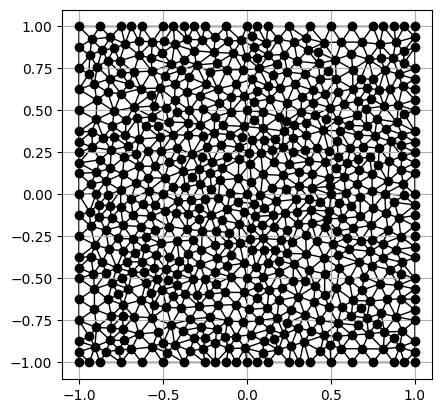

In [25]:
gedim.PlotMesh(mesh)

### Create Discrete Space FEM

In [26]:
discreteSpace = { 'Order': order, 'Type': 1, 'BoundaryConditionsType': [1, 3, 3, 2] }
[problemData, dofs, strongs] = gedim.Discretize(discreteSpace, lib)

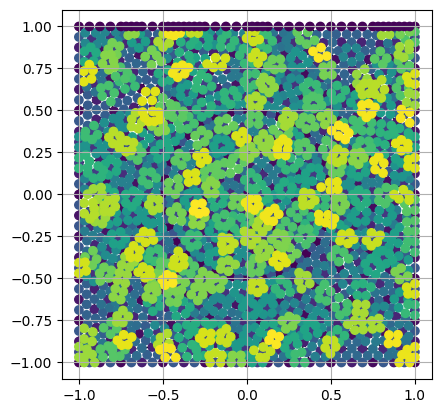

In [27]:
gedim.PlotDofs(mesh, dofs, strongs)

### Assemble linear system

In [28]:
[stiffness, stiffnessStrong] = gedim.AssembleStiffnessMatrix(Heat_k, problemData, lib)

weakTerm_down = gedim.AssembleWeakTerm(Heat_weakTerm_down, 1, problemData, lib)

### Solve linear system

In [29]:
solution = gedim.LUSolver(stiffness, weakTerm_down, lib)

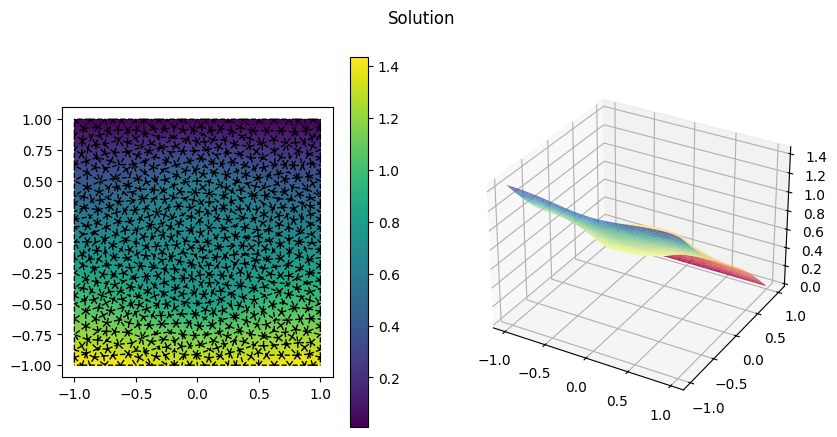

In [30]:
gedim.PlotSolution(mesh, dofs, strongs, solution, np.zeros(problemData['NumberStrongs']))

In [31]:
gedim.ExportSolution(Empty_exactSolution, solution, np.zeros(problemData['NumberStrongs']), lib)